In this code we run the Kth Nearest Neighbours (KNN) Model on the S&P500 returns and momentum indicators.

We first compute momentum indicators (MACD), split training and testing samples, clean and format the data, compute correlations and run the KNN model to create Overvalued and Undervalued trading signals, with charts.


In [ ]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import warnings

warnings.filterwarnings('ignore')

In [ ]:
# Step 1. Download ticker data from Yahoo Finance
yfticker = yf.Ticker('^GSPC') #Here we will use the S&P500
yfdata = yfticker.history(period='max')

# Step 2. Add momentum indicators to the model
#Using pandas functionalities here, refer to my other work on these computations via numpy for details (incl. EWA computation for MACD)
yfdata['daily_volume'] = yfdata['Volume'].diff()
yfdata['daily_return'] = yfdata['Close'].pct_change()
yfdata['30d_ma'] = yfdata['Close'].rolling(30).mean()
yfdata['daily_range'] = yfdata['High'] - yfdata['Low']
yfdata['30d_std'] = yfdata['Close'].rolling(30).std()

# Add MACD indicator
yfdata['macd'] = yfdata['Close'].ewm(span=12, adjust=False).mean() - yfdata['Close'].ewm(span=26, adjust=False).mean()

# Smoothed MACD line
yfdata['signal'] = yfdata['macd'].ewm(span=9, adjust=False).mean()

In [ ]:
# Step 3. Split the Data for Training and Out-of-Sample Testing, with testing on the last 365 days
train_sample = yfdata.iloc[:-365, :]
test_sample = yfdata.iloc[-365:, :]

# Handle missing values in the training data
#X is the indicators matrix, Y is the price serie
missingtomean = SimpleImputer(strategy='mean')
X_train = train_sample[['daily_volume', 'daily_return', '30d_ma', 'daily_range', '30d_std', 'macd', 'signal']]
X_train = pd.DataFrame(missingtomean.fit_transform(X_train), columns=X_train.columns)
y_train = train_sample['Close']
X_test = test_sample[['daily_volume', 'daily_return', '30d_ma', 'daily_range', '30d_std', 'macd', 'signal']]
y_test = test_sample['Close']

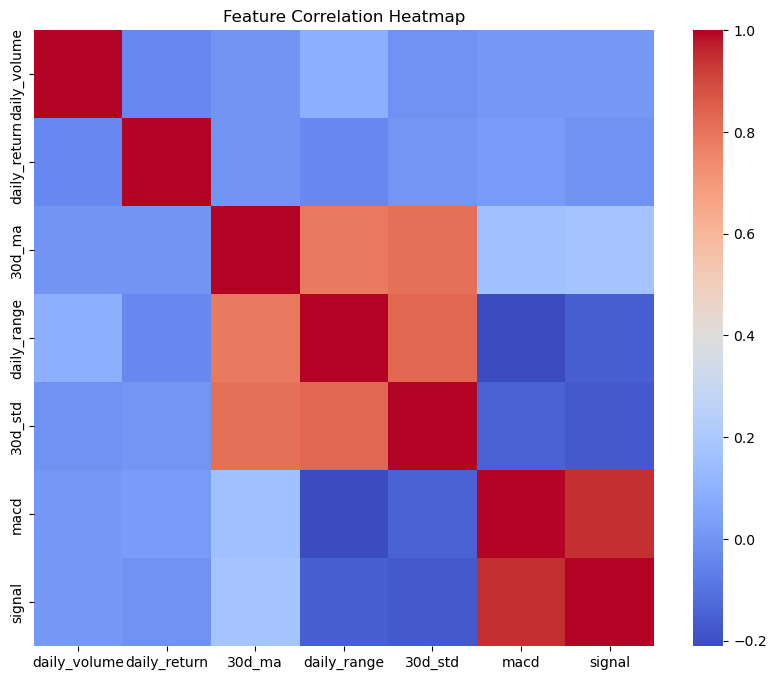

In [ ]:
# Step 4. Check Correlations between Features
corr = X_train.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()

In [10]:
# Step 5. Run the Kth Nearest Neighbours (KNN) Model
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

# Step 6. Create price indicator
y_predic = knn.predict(X_test)
test_sample.loc[:, 'price_indicator'] = (y_test - y_predic) / y_test

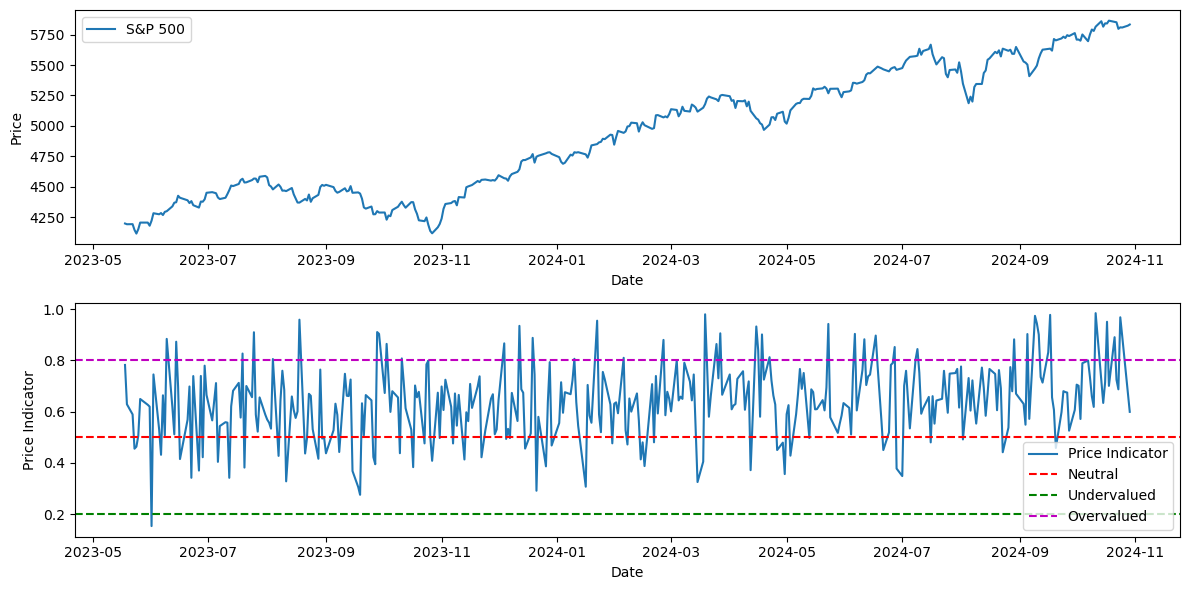

In [11]:
# Step 7. Plot price and indicator
plt.figure(figsize=(12, 6))

# Plot actual Price
plt.subplot(2, 1, 1)
plt.plot(test_sample.index, test_sample['Close'], label='S&P 500')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

# Plot Price Indicator
plt.subplot(2, 1, 2)
plt.plot(test_sample.index, test_sample['price_indicator'], label='Price Indicator')
plt.axhline(y=0.5, color='r', linestyle='--', label='Neutral')
plt.axhline(y=0.2, color='g', linestyle='--', label='Undervalued')
plt.axhline(y=0.8, color='m', linestyle='--', label='Overvalued')
plt.xlabel('Date')
plt.ylabel('Price Indicator')
plt.legend()

plt.tight_layout()
plt.show()